In [212]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt    
import os 
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from definitions import *
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
matplotlib.rcParams["figure.dpi"] = 150
from particle import PDGID
from utils import delphesRootToPixelAvTrackList as utils                           

In [213]:
def cutData(truth, recon, data, symbol, val, data2=None, symbol2=None, val2=None):
    if symbol == '>':
        cut = truth[data]>val
    elif symbol == '<':
        cut = truth[data]<val
    elif symbol == '>=':
        cut = truth[data]>=val
    elif symbol == '<=':
        cut = truth[data]<=val
    elif symbol == '==':
        cut = truth[data]==val
    
    if data2 != None:
        if symbol2 == '>':
            cut2 = truth[data2]>val2
        elif symbol2 == '<':
            cut2 = truth[data2]<val2
        elif symbol2 == '>=':
            cut2 = truth[data2]>=val2
        elif symbol2 == '<=':
            cut2 = truth[data2]<=val2
        elif symbol2 == '==':
            cut2 = truth[data2]==val2
        cut = cut & cut2

    truthCut = truth[cut] #.reset_index(inplace=True)
    reconCut = recon[cut] #.reset_index(inplace=True)

    truthCut.reset_index(inplace=True, drop=True)
    reconCut.reset_index(inplace=True, drop=True)

    clustersCut = reconCut.to_numpy().reshape(reconCut.shape[0],13,21)
    
    return truthCut, reconCut, clustersCut

def getYProfiles(clusters):
    profiles = np.sum(clusters, axis = 2)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageYProfile(clusters):
    profiles=getYProfiles(clusters)
    return np.mean(profiles, axis=0)

def getXProfiles(clusters):
    profiles = np.sum(clusters, axis = 1)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageXProfile(clusters):
    profiles=getXProfiles(clusters)
    return np.mean(profiles, axis=0)

def getClusterYSizes(clusters):
    profiles=getYProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterYSize(clusters):
    clusterSizes = getClusterYSizes(clusters)
    return np.mean(clusterSizes)

def getClusterXSizes(clusters):
    profiles=getXProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterXSize(clusters):
    clusterSizes = getClusterXSizes(clusters)
    return np.mean(clusterSizes)

def GetMeanVectorY(clusters):
    clusterSizes = getAverageYProfile(clusters)
    return np.mean(clusterSizes)

def getCovarianceMatrixY(clusters):

    # Get the cluster size profile (non-zero pixels along axis 1 and 2 for each cluster)
    clusterProfiles = getYProfiles(clusters)

    # Compute the covariance matrix
    covariance_matrix = np.cov(clusterProfiles, rowvar=False)
    
    return covariance_matrix

# Lets Find the distance
from scipy.stats import chi2

def Mahalanobis_Distance(cov_matrix, mean_vector, random_vector):
    """
    Compute the Mahalanobis distance using the pseudoinverse for singular covariance matrices.

    Parameters:
        cov_matrix (numpy.ndarray): Covariance matrix of the distribution (shape: n x n).
        mean_vector (numpy.ndarray): Mean vector of the distribution (shape: n,).
        random_vector (numpy.ndarray): Input random vector (shape: n,).

    Returns:
        float: The Mahalanobis distance.
    """
    # Convert inputs to numpy arrays if they are not already
    cov_matrix = np.asarray(cov_matrix)
    mean_vector = np.asarray(mean_vector)
    random_vector = np.asarray(random_vector)

    # Ensure the dimensions match
    if mean_vector.shape[0] != random_vector.shape[0]:
        raise ValueError("Mean vector and random vector dimensions do not match.")
    if cov_matrix.shape[0] != cov_matrix.shape[1] or cov_matrix.shape[0] != mean_vector.shape[0]:
        raise ValueError("Covariance matrix dimensions must match the length of the mean vector.")
    
    # Compute the difference vector
    diff = random_vector - mean_vector

    # Compute the pseudoinverse of the covariance matrix
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    # Compute Mahalanobis distance
    distance = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return distance

def Mahalanobis_Probability(D_M, d):
    """
    Compute the probability (p-value) that a vector belongs to a given distribution.

    Parameters:
        D_M (float): Mahalanobis distance.
        d (int): Degrees of freedom (dimensionality of the vector).

    Returns:
        float: Probability that the vector belongs to the distribution.
    """
    # Compute the squared Mahalanobis distance
    D_M_squared = D_M ** 2
    
    # Compute the cumulative distribution function (CDF) for chi-squared distribution
    chi2_cdf = chi2.cdf(D_M_squared, df=d)
    
    # Compute the probability (p-value)
    p_value = 1 - chi2_cdf
    
    return p_value

In [214]:
datadir = '/home/youeric/PixelSim/PixSim/'
flp = 0

In [215]:
truthbib = pd.DataFrame()
recon2Dbib = pd.DataFrame()
truthsig = pd.DataFrame()
recon2Dsig = pd.DataFrame()

for file in os.listdir(datadir):
    if "labels" in file:
        if "bib" in file: 
            truthbib = pd.concat([truthbib,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dbib = pd.concat([recon2Dbib,pd.read_parquet(f"{datadir}{file}")])
        elif "sig" in file: 
            truthsig = pd.concat([truthsig,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dsig = pd.concat([recon2Dsig,pd.read_parquet(f"{datadir}{file}")])
            
clustersSig = recon2Dsig.to_numpy().reshape(recon2Dsig.shape[0],13,21)
clustersBib = recon2Dbib.to_numpy().reshape(recon2Dbib.shape[0],13,21)

In [216]:
# Seperate into out by ylocal

TruthsigLow, recon2DsigLow, clusterssigLow = cutData(truthsig, recon2Dsig, 'y-local', '<', -2)
TruthsigMid, recon2DsigMid, clusterssigMid = cutData(truthsig, recon2Dsig, 'y-local', '>', 0, 'y-local', '<', 2)
TruthsigHigh, recon2DsigHigh, clusterssigHigh = cutData(truthsig, recon2Dsig, 'y-local', '>', 6)

profilesigLow = getAverageYProfile(clusterssigLow)
profilesigMid = getAverageYProfile(clusterssigMid)
profilesigHigh = getAverageYProfile(clusterssigHigh)

TruthbibLow, recon2DbibLow, clustersbibLow = cutData(truthbib, recon2Dbib, 'y-local', '<', -2)
TruthbibMid, recon2DbibMid, clustersbibMid = cutData(truthbib, recon2Dbib, 'y-local', '>', 0, 'y-local', '<', 2)
TruthbibHigh, recon2DbibHigh, clustersbibHigh = cutData(truthbib, recon2Dbib, 'y-local', '>', 6)

profilebibLow = getAverageYProfile(clustersbibLow)
profilebibMid = getAverageYProfile(clustersbibMid)
profilebibHigh = getAverageYProfile(clustersbibHigh)

In [217]:
def remove_outliers_by_iqr(clusters):
    # Compute the Y profiles
    y_profiles = getYProfiles(clusters)
    
    # Calculate IQR for each element (column)
    Q1 = np.percentile(y_profiles, 25, axis=0)  # 25th percentile (Q1)
    Q3 = np.percentile(y_profiles, 75, axis=0)  # 75th percentile (Q3)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify clusters that are within bounds for all elements
    within_bounds = np.all((y_profiles >= lower_bound) & (y_profiles <= upper_bound), axis=1)
    
    # Filter out outlier clusters
    filtered_clusters = clusters[within_bounds]
    
    return filtered_clusters

# Apply the IQR outlier removal to each cluster dataset
filtered_clusterssigLow = remove_outliers_by_iqr(clusterssigLow)
filtered_clusterssigMid = remove_outliers_by_iqr(clusterssigMid)
filtered_clusterssigHigh = remove_outliers_by_iqr(clusterssigHigh)

filtered_profilesigLow = getAverageYProfile(filtered_clusterssigLow)
filtered_profilesigMid = getAverageYProfile(filtered_clusterssigMid)
filtered_profilesigHigh = getAverageYProfile(filtered_clusterssigHigh)

# Print the results
print(f"Original clusterssigLow shape: {clusterssigLow.shape}, Filtered: {filtered_clusterssigLow.shape}")
print(f"Original clusterssigMid shape: {clusterssigMid.shape}, Filtered: {filtered_clusterssigMid.shape}")
print(f"Original clusterssigHigh shape: {clusterssigHigh.shape}, Filtered: {filtered_clusterssigHigh.shape}")

Original clusterssigLow shape: (7187, 13, 21), Filtered: (3997, 13, 21)
Original clusterssigMid shape: (6032, 13, 21), Filtered: (3224, 13, 21)
Original clusterssigHigh shape: (7384, 13, 21), Filtered: (4627, 13, 21)


In [218]:
# Apply the IQR outlier removal to each cluster dataset for bib particles
filtered_clustersbibLow = remove_outliers_by_iqr(clustersbibLow)
filtered_clustersbibMid = remove_outliers_by_iqr(clustersbibMid)
filtered_clustersbibHigh = remove_outliers_by_iqr(clustersbibHigh)

# Compute the mean profiles for the filtered bib clusters
filtered_profilebibLow = getAverageYProfile(filtered_clustersbibLow)
filtered_profilebibMid = getAverageYProfile(filtered_clustersbibMid)
filtered_profilebibHigh = getAverageYProfile(filtered_clustersbibHigh)

# Print the results
print(f"Original clustersbibLow shape: {clustersbibLow.shape}, Filtered: {filtered_clustersbibLow.shape}")
print(f"Original clustersbibMid shape: {clustersbibMid.shape}, Filtered: {filtered_clustersbibMid.shape}")
print(f"Original clustersbibHigh shape: {clustersbibHigh.shape}, Filtered: {filtered_clustersbibHigh.shape}")

print("Filtered profilebibLow mean profile:", filtered_profilebibLow)
print("Filtered profilebibMid mean profile:", filtered_profilebibMid)
print("Filtered profilebibHigh mean profile:", filtered_profilebibHigh)

Original clustersbibLow shape: (6268, 13, 21), Filtered: (2685, 13, 21)
Original clustersbibMid shape: (5585, 13, 21), Filtered: (2364, 13, 21)
Original clustersbibHigh shape: (6328, 13, 21), Filtered: (2590, 13, 21)
Filtered profilebibLow mean profile: [0.00000000e+00 4.31314711e+01 3.38220857e+02 1.10942160e+03
 2.15275568e+03 2.45063687e+03 1.71955531e+03 7.38745996e+02
 1.68315829e+02 2.10837989e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Filtered profilebibMid mean profile: [0.00000000e+00 3.32538071e+01 2.88917090e+02 1.07716836e+03
 2.18893316e+03 2.55025508e+03 1.74694459e+03 6.73560914e+02
 1.41652707e+02 1.37225042e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Filtered profilebibHigh mean profile: [   0.           41.34324324  341.70540541 1130.42625483 2259.86023166
 2608.10926641 1712.4957529   658.53359073  159.4011583     5.4984556
    0.            0.            0.        ]


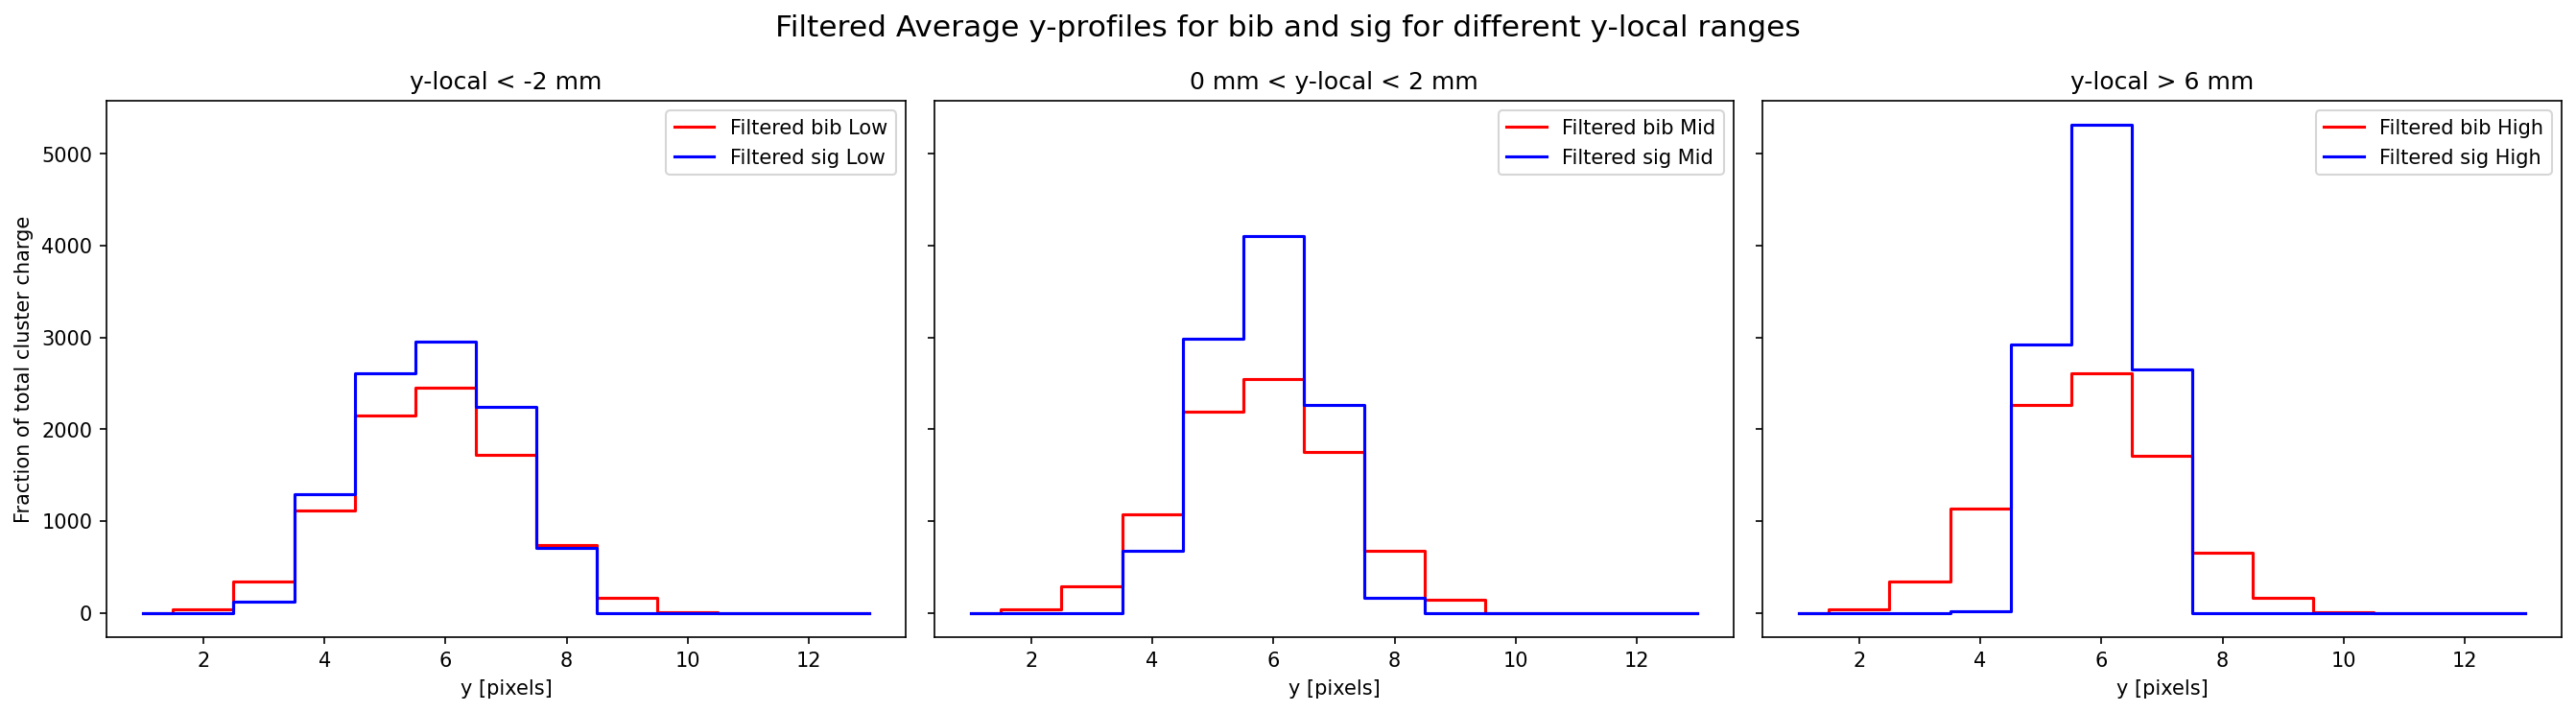

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Replace these with the actual filtered profile data
yaxis = np.arange(1, len(filtered_profilebibLow) + 1, 1)

# Plot
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

# Plot for Low profiles
ax[0].step(yaxis, filtered_profilebibLow, where="mid", label="Filtered bib Low", c='r')
ax[0].step(yaxis, filtered_profilesigLow, where="mid", label="Filtered sig Low", c='b')
ax[0].legend()
ax[0].set_title("y-local < -2 mm")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

# Plot for Mid profiles
ax[1].step(yaxis, filtered_profilebibMid, where="mid", label="Filtered bib Mid", c='r')
ax[1].step(yaxis, filtered_profilesigMid, where="mid", label="Filtered sig Mid", c='b')
ax[1].legend()
ax[1].set_title("0 mm < y-local < 2 mm")
ax[1].set_xlabel("y [pixels]")

# Plot for High profiles
ax[2].step(yaxis, filtered_profilebibHigh, where="mid", label="Filtered bib High", c='r')
ax[2].step(yaxis, filtered_profilesigHigh, where="mid", label="Filtered sig High", c='b')
ax[2].legend()
ax[2].set_title("y-local > 6 mm")
ax[2].set_xlabel("y [pixels]")

# Add an overall title and layout adjustments
fig.suptitle('Filtered Average y-profiles for bib and sig for different y-local ranges', fontsize=15)
plt.tight_layout()
plt.show()


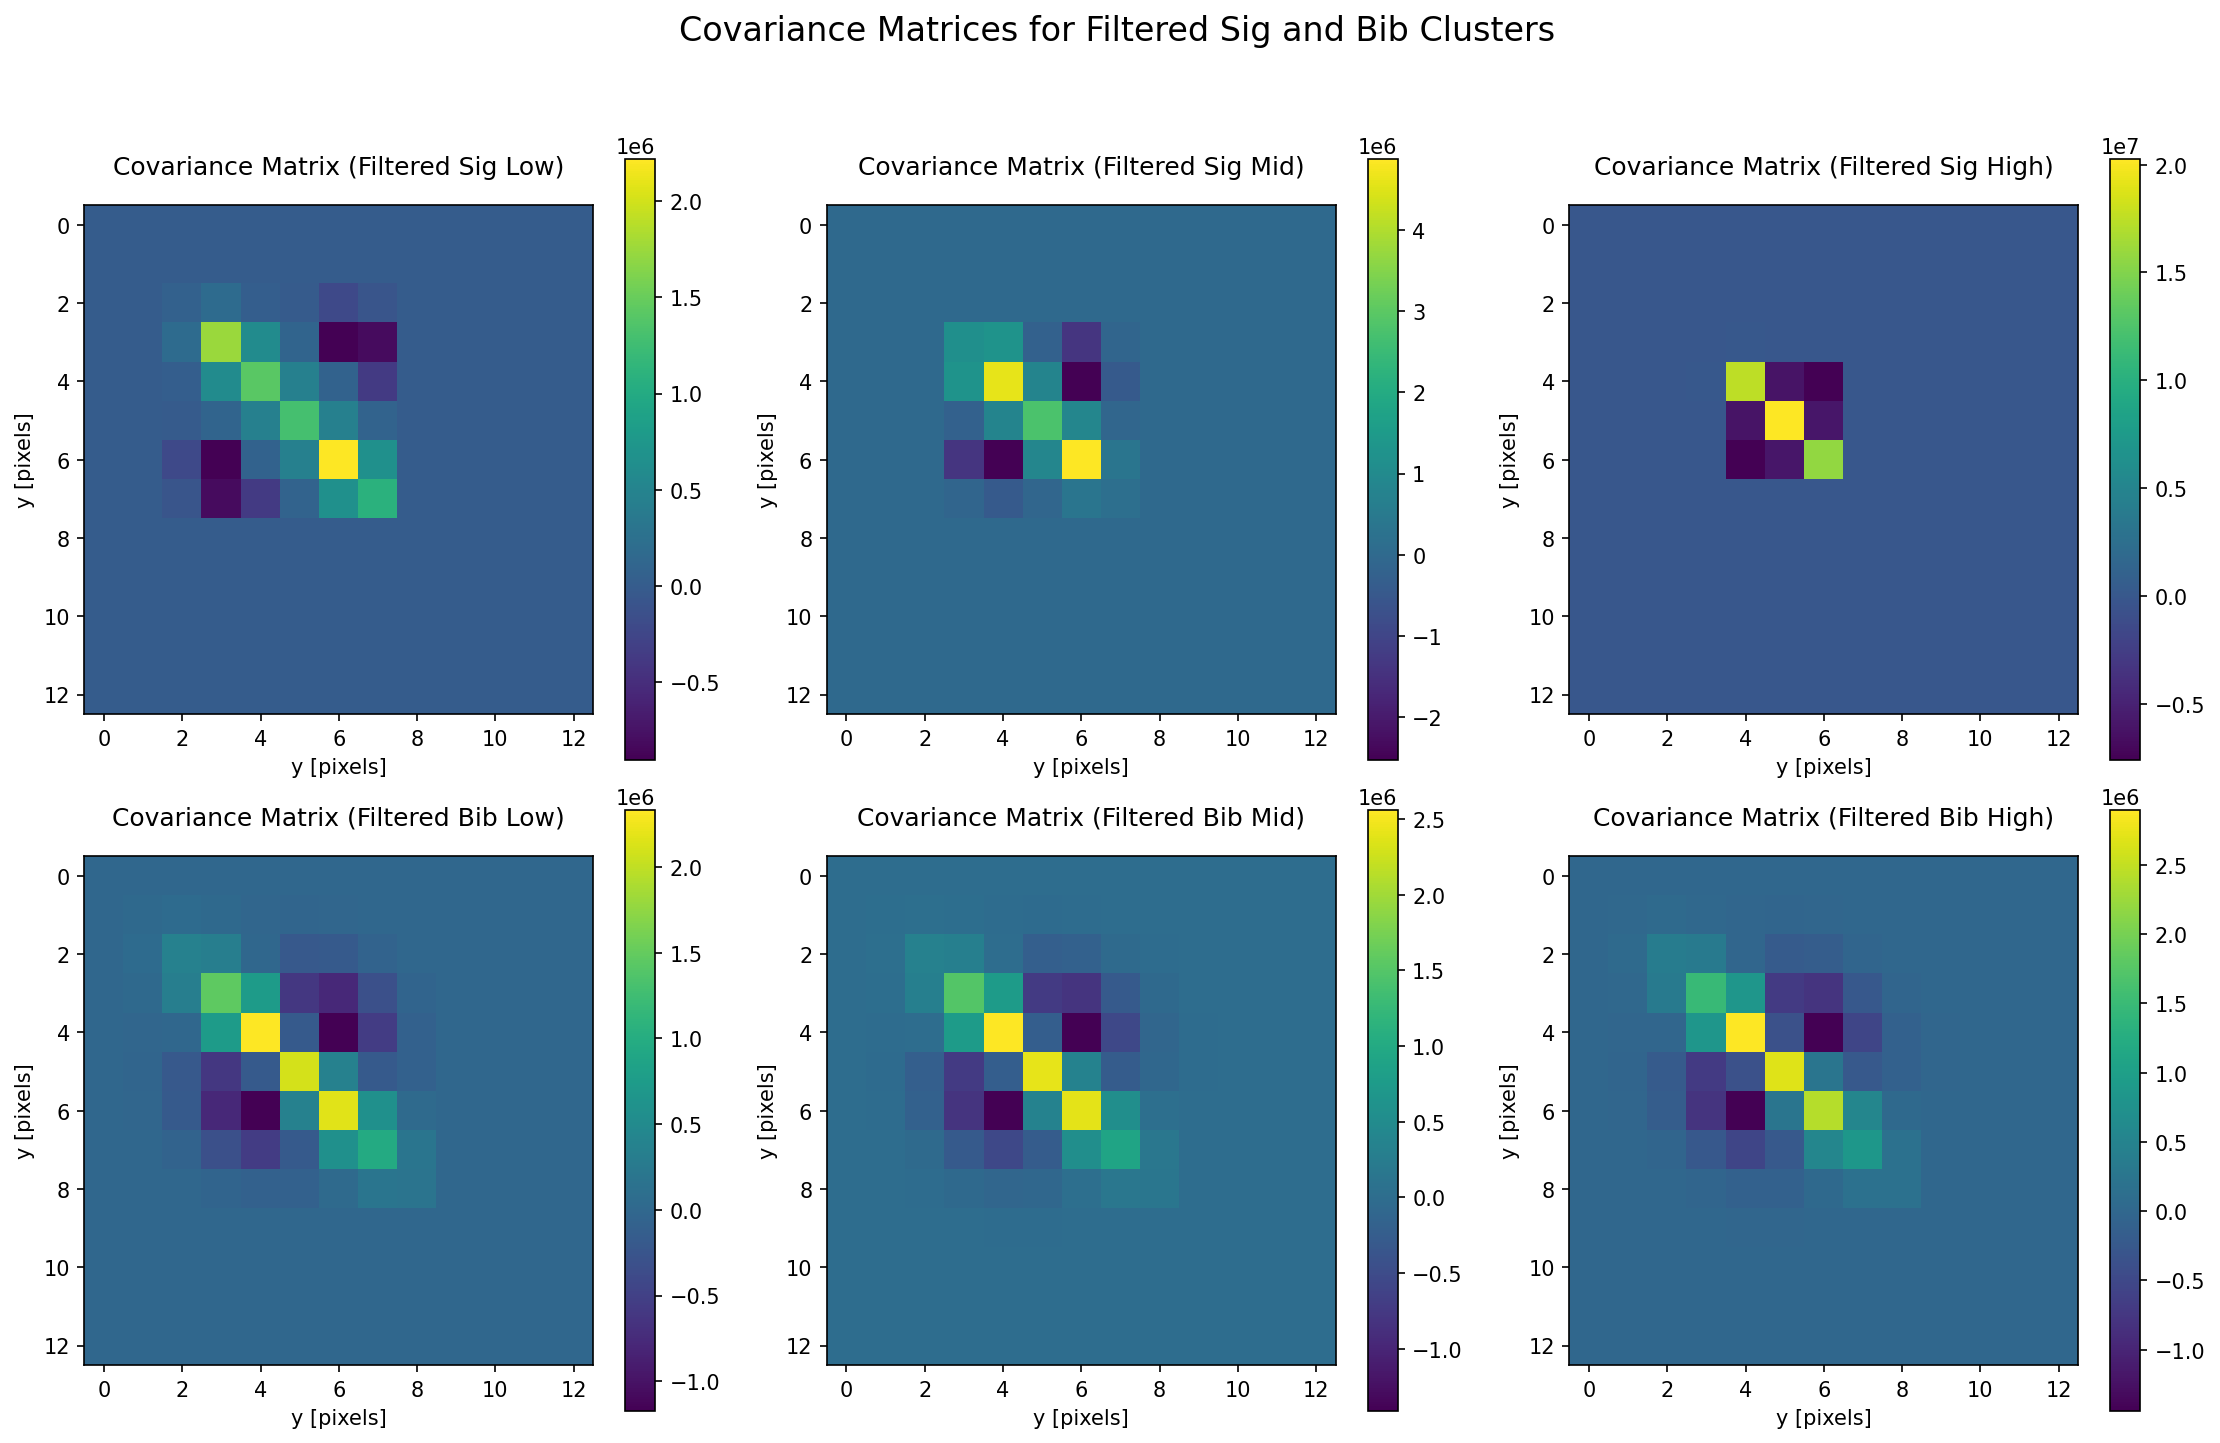

In [220]:
import matplotlib.pyplot as plt

# Replace these with the actual covariance matrix computation for the filtered data
covariance_matrix_sig_low_filtered = getCovarianceMatrixY(filtered_clusterssigLow)
covariance_matrix_sig_mid_filtered = getCovarianceMatrixY(filtered_clusterssigMid)
covariance_matrix_sig_high_filtered = getCovarianceMatrixY(filtered_clusterssigHigh)

covariance_matrix_bib_low_filtered = getCovarianceMatrixY(filtered_clustersbibLow)
covariance_matrix_bib_mid_filtered = getCovarianceMatrixY(filtered_clustersbibMid)
covariance_matrix_bib_high_filtered = getCovarianceMatrixY(filtered_clustersbibHigh)

# Plot Covariance Matrices for the filtered data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Sig covariance matrices
im = axes[0, 0].imshow(covariance_matrix_sig_low_filtered, cmap='viridis')
axes[0, 0].set_title('Covariance Matrix (Filtered Sig Low)', pad=15)
axes[0, 0].set_xlabel('y [pixels]')
axes[0, 0].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(covariance_matrix_sig_mid_filtered, cmap='viridis')
axes[0, 1].set_title('Covariance Matrix (Filtered Sig Mid)', pad=15)
axes[0, 1].set_xlabel('y [pixels]')
axes[0, 1].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 1])

im = axes[0, 2].imshow(covariance_matrix_sig_high_filtered, cmap='viridis')
axes[0, 2].set_title('Covariance Matrix (Filtered Sig High)', pad=15)
axes[0, 2].set_xlabel('y [pixels]')
axes[0, 2].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[0, 2])

# Bib covariance matrices
im = axes[1, 0].imshow(covariance_matrix_bib_low_filtered, cmap='viridis')
axes[1, 0].set_title('Covariance Matrix (Filtered Bib Low)', pad=15)
axes[1, 0].set_xlabel('y [pixels]')
axes[1, 0].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(covariance_matrix_bib_mid_filtered, cmap='viridis')
axes[1, 1].set_title('Covariance Matrix (Filtered Bib Mid)', pad=15)
axes[1, 1].set_xlabel('y [pixels]')
axes[1, 1].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 1])

im = axes[1, 2].imshow(covariance_matrix_bib_high_filtered, cmap='viridis')
axes[1, 2].set_title('Covariance Matrix (Filtered Bib High)', pad=15)
axes[1, 2].set_xlabel('y [pixels]')
axes[1, 2].set_ylabel('y [pixels]')
plt.colorbar(im, ax=axes[1, 2])

# Set overall title and adjust layout
fig.suptitle('Covariance Matrices for Filtered Sig and Bib Clusters', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust padding to prevent overlap
plt.show()


In [221]:
# Extract the standard deviation (square root of the variance) from the diagonal of the covariance matrices
std_diag_covariance_matrix_sig_low_filtered = np.sqrt(np.diag(covariance_matrix_sig_low_filtered))
std_diag_covariance_matrix_sig_mid_filtered = np.sqrt(np.diag(covariance_matrix_sig_mid_filtered))
std_diag_covariance_matrix_sig_high_filtered = np.sqrt(np.diag(covariance_matrix_sig_high_filtered))

# Output the results
print("Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Low):")
print(std_diag_covariance_matrix_sig_low_filtered)

print("\nStandard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Mid):")
print(std_diag_covariance_matrix_sig_mid_filtered)

print("\nStandard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig High):")
print(std_diag_covariance_matrix_sig_high_filtered)

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Low):
[   0.            0.          263.64550363 1321.85647567 1191.23874021
 1138.96073908 1489.31598182 1043.03677526    0.            0.
    0.            0.            0.        ]

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig Mid):
[   0.            0.            2.84949426 1078.86842105 2142.25000554
 1665.87837594 2208.14452154  399.82951781    0.            0.
    0.            0.            0.        ]

Standard deviation of each bin (diagonal entries) in the covariance matrix (Filtered Sig High):
[   0.            0.            0.           56.11006517 4180.42100943
 4499.74056859 3969.28680277    0.            0.            0.
    0.            0.            0.        ]


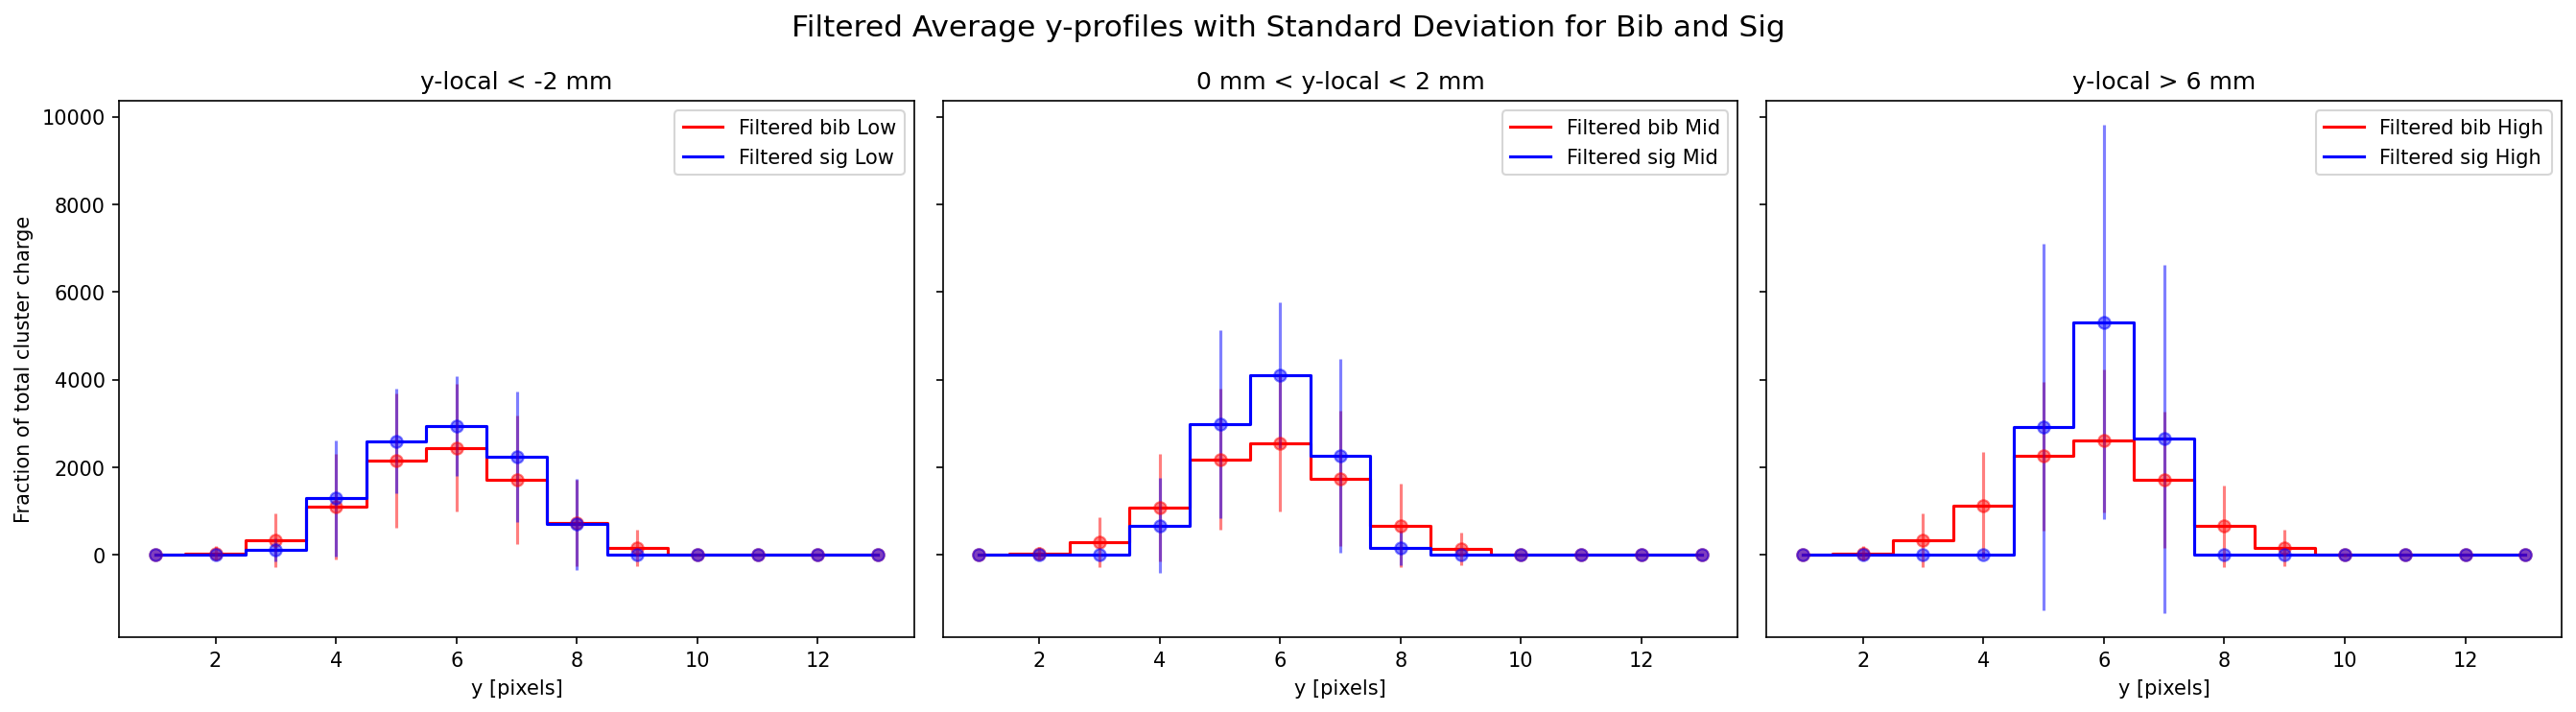

In [249]:
# Define the y-axis and data (replace these with actual filtered profile data and std deviations)
yaxis = np.arange(1, len(filtered_profilebibLow) + 1, 1)
std_profilebibLow = np.std(getYProfiles(filtered_clustersbibLow), axis=0)
std_profilebibMid = np.std(getYProfiles(filtered_clustersbibMid), axis=0)
std_profilebibHigh = np.std(getYProfiles(filtered_clustersbibHigh), axis=0)
std_profilesigLow = np.std(getYProfiles(filtered_clusterssigLow), axis=0)
std_profilesigMid = np.std(getYProfiles(filtered_clusterssigMid), axis=0)
std_profilesigHigh = np.std(getYProfiles(filtered_clusterssigHigh), axis=0)

# Plot
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))

# Plot for Low profiles with whiskers
ax[0].step(yaxis, filtered_profilebibLow, where="mid", label="Filtered bib Low", color='r')
ax[0].step(yaxis, filtered_profilesigLow, where="mid", label="Filtered sig Low", color='b')
ax[0].errorbar(yaxis, filtered_profilebibLow, yerr=std_profilebibLow, fmt='o', color='r', alpha=0.5)
ax[0].errorbar(yaxis, filtered_profilesigLow, yerr=std_profilesigLow, fmt='o', color='b', alpha=0.5)
ax[0].legend()
ax[0].set_title("y-local < -2 mm")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

# Plot for Mid profiles with whiskers
ax[1].step(yaxis, filtered_profilebibMid, where="mid", label="Filtered bib Mid", color='r')
ax[1].step(yaxis, filtered_profilesigMid, where="mid", label="Filtered sig Mid", color='b')
ax[1].errorbar(yaxis, filtered_profilebibMid, yerr=std_profilebibMid, fmt='o', color='r', alpha=0.5)
ax[1].errorbar(yaxis, filtered_profilesigMid, yerr=std_profilesigMid, fmt='o', color='b', alpha=0.5)
ax[1].legend()
ax[1].set_title("0 mm < y-local < 2 mm")
ax[1].set_xlabel("y [pixels]")

# Plot for High profiles with whiskers
ax[2].step(yaxis, filtered_profilebibHigh, where="mid", label="Filtered bib High", color='r')
ax[2].step(yaxis, filtered_profilesigHigh, where="mid", label="Filtered sig High", color='b')
ax[2].errorbar(yaxis, filtered_profilebibHigh, yerr=std_profilebibHigh, fmt='o', color='r', alpha=0.5)
ax[2].errorbar(yaxis, filtered_profilesigHigh, yerr=std_profilesigHigh, fmt='o', color='b', alpha=0.5)
ax[2].legend()
ax[2].set_title("y-local > 6 mm")
ax[2].set_xlabel("y [pixels]")

# Add an overall title and layout adjustments
fig.suptitle('Filtered Average y-profiles with Standard Deviation for Bib and Sig', fontsize=15)
plt.tight_layout()
plt.show()

In [223]:
cov_matrix = covariance_matrix_sig_low_filtered
mean_vector = filtered_profilesigLow

# Random vector to test (same length as mean_vector)
random_vector = np.random.rand(mean_vector.shape[0])

# random_vector = np.zeros_like(mean_vector)

# Compute the Mahalanobis distance
distance = Mahalanobis_Distance(cov_matrix, mean_vector, random_vector)

print(Mahalanobis_Probability(distance, mean_vector.shape[0]))

0.4955688204627916


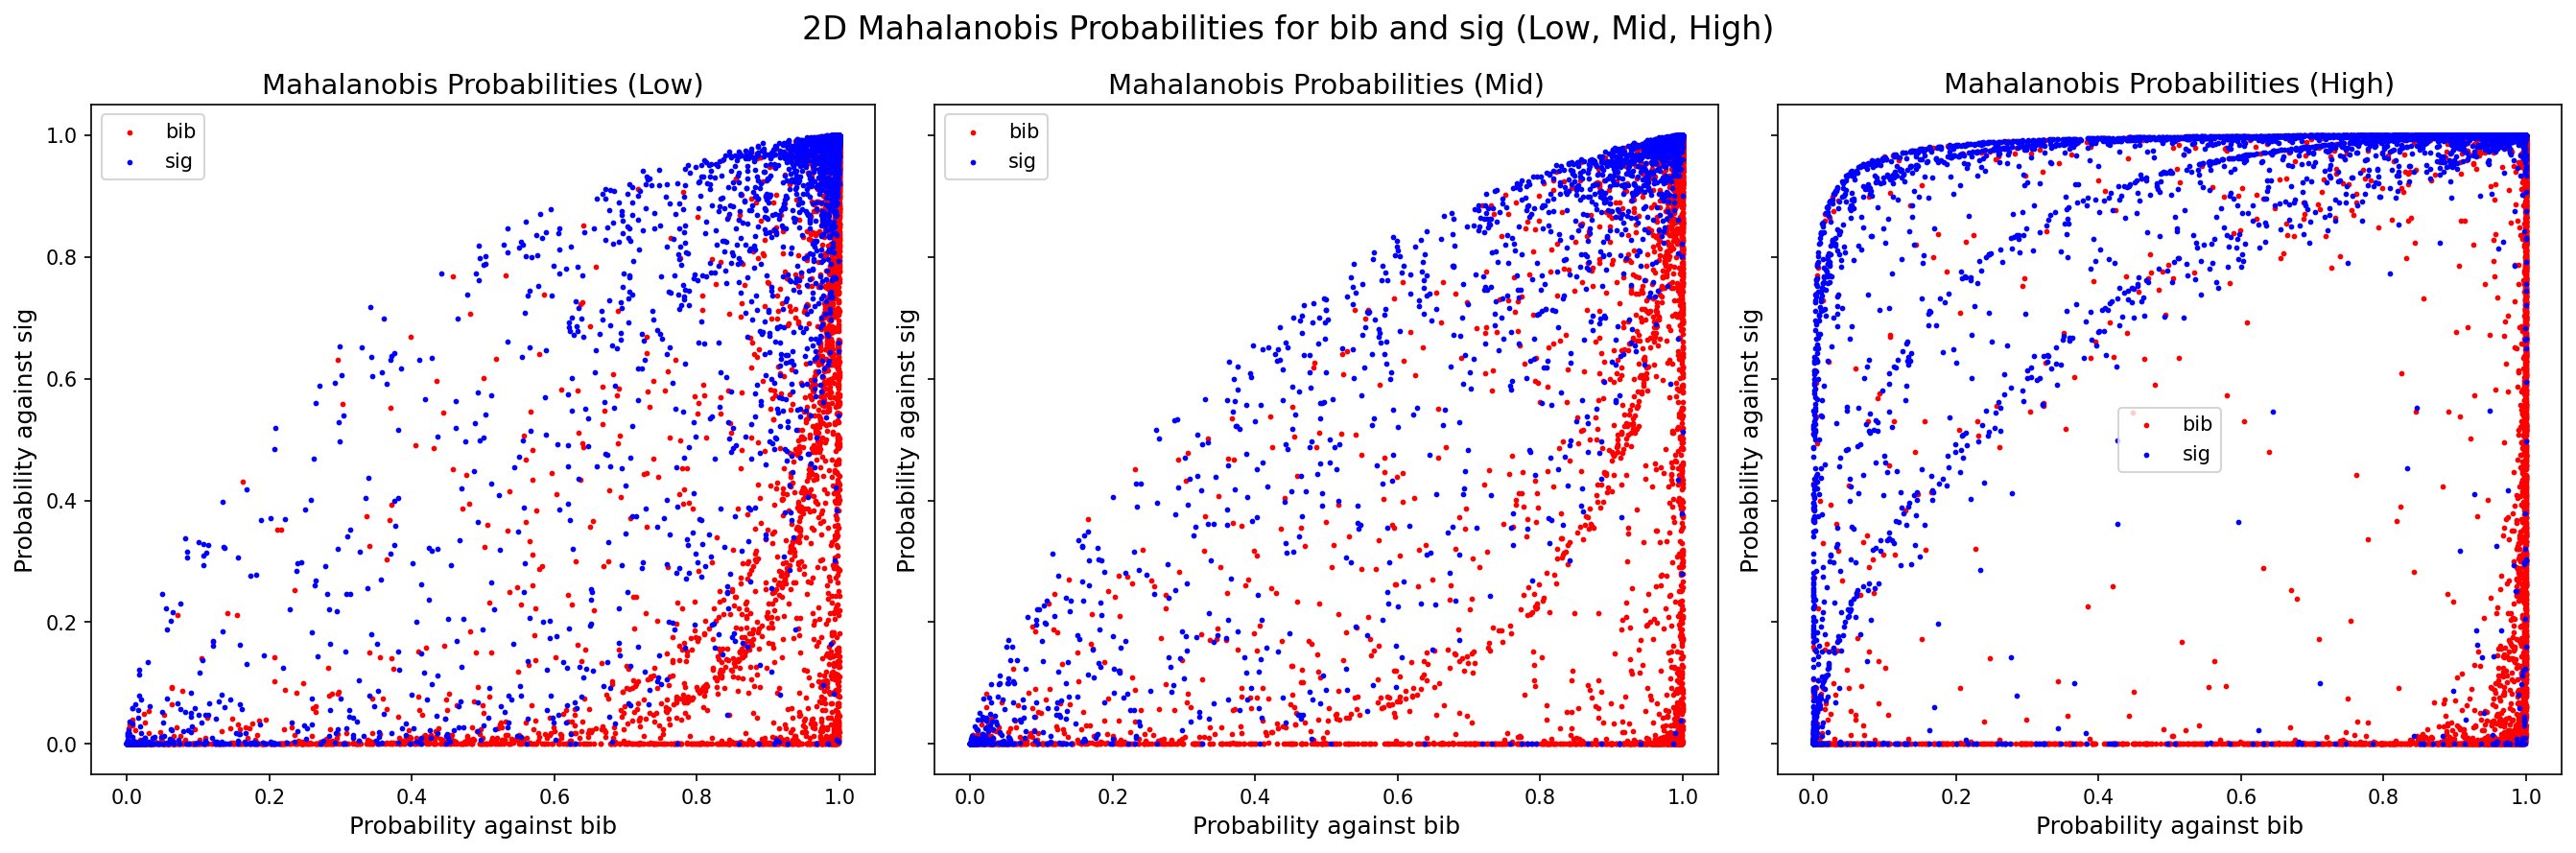

In [224]:

# Define a function to create the plots for given datasets and references

def compute_probabilities_2d(dataset, reference_datasets):
    """
    Compute probabilities for each profile in a dataset against two reference datasets.

    Parameters:
        dataset: The dataset to process (e.g., clustersLow1).
        reference_datasets: List of two reference datasets for covariance and mean.

    Returns:
        List of tuples containing probabilities for the dataset against each reference.
    """
    probabilities = []
    for profile in getYProfiles(dataset):
        prob_ref1 = Mahalanobis_Probability(
            Mahalanobis_Distance(
                getCovarianceMatrixY(reference_datasets[0]),
                getAverageYProfile(reference_datasets[0]),
                profile
            ),
            getAverageYProfile(reference_datasets[0]).shape[0]
        )
        prob_ref2 = Mahalanobis_Probability(
            Mahalanobis_Distance(
                getCovarianceMatrixY(reference_datasets[1]),
                getAverageYProfile(reference_datasets[1]),
                profile
            ),
            getAverageYProfile(reference_datasets[1]).shape[0]
        )
        probabilities.append((prob_ref1, prob_ref2))
    return probabilities


def create_2d_mahalanobis_plot(datasets, dataset_labels, dataset_colors, reference_datasets, plot_title, ax):
    """
    Create a 2D scatter plot for Mahalanobis probabilities.

    Parameters:
        datasets: List of datasets to process.
        dataset_labels: List of labels for the datasets.
        dataset_colors: List of colors for the datasets.
        reference_datasets: List of two reference datasets.
        plot_title: Title of the plot.
        ax: Axis object to plot on.
    """
    all_probabilities_2d = {}
    for idx, dataset in enumerate(datasets):
        dataset_name = dataset_labels[idx]
        all_probabilities_2d[dataset_name] = compute_probabilities_2d(dataset, reference_datasets)

    for idx, dataset_name in enumerate(dataset_labels):
        probabilities = all_probabilities_2d[dataset_name]
        probs_ref1, probs_ref2 = zip(*probabilities)

        ax.scatter(probs_ref1, probs_ref2,
                   c=dataset_colors[idx], marker='o', s=3,
                   label=f'{dataset_name}')
    
    ax.set_xlabel(f'Probability against {dataset_labels[0]}', fontsize=12)
    ax.set_ylabel(f'Probability against {dataset_labels[1]}', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='best')

# Datasets, labels, and colors
datasets_low = [clustersbibLow, clusterssigLow]
datasets_mid = [clustersbibMid, clusterssigMid]
datasets_high = [clustersbibHigh, clusterssigHigh]

dataset_labels = ['bib', 'sig']
dataset_colors = ['red', 'blue']

# Create subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Low
create_2d_mahalanobis_plot(datasets_low, dataset_labels, dataset_colors,
                           datasets_low, 'Mahalanobis Probabilities (Low)', axes[0])

# Plot for Mid
create_2d_mahalanobis_plot(datasets_mid, dataset_labels, dataset_colors,
                           datasets_mid, 'Mahalanobis Probabilities (Mid)', axes[1])

# Plot for High
create_2d_mahalanobis_plot(datasets_high, dataset_labels, dataset_colors,
                           datasets_high, 'Mahalanobis Probabilities (High)', axes[2])

# Add an overall title and show the plots
fig.suptitle('2D Mahalanobis Probabilities for bib and sig (Low, Mid, High)', fontsize=16)
plt.tight_layout()
plt.show()

In [226]:
import numpy as np

# Define the custom function
def custom_function(x, a, shift=0.01):
    """
    Custom function used for filtering data points.
    Parameters:
        x: Input x-coordinate.
        a: Parameter defining the function behavior.
        shift: Shift parameter for the function.
    Returns:
        Computed y-coordinate for the function.
    """
    f_a = np.tan(np.pi * a / 2)
    result = (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift
    return result


# Compute probabilities for Low, Mid, and High datasets
probabilities_low = {}
probabilities_mid = {}
probabilities_high = {}

# Compute probabilities for Low datasets
probabilities_low['bibLow'] = compute_probabilities_2d(datasets_low[0], datasets_low)
probabilities_low['sigLow'] = compute_probabilities_2d(datasets_low[1], datasets_low)

# Compute probabilities for Mid datasets
probabilities_mid['bibMid'] = compute_probabilities_2d(datasets_mid[0], datasets_mid)
probabilities_mid['sigMid'] = compute_probabilities_2d(datasets_mid[1], datasets_mid)

# Compute probabilities for High datasets
probabilities_high['bibHigh'] = compute_probabilities_2d(datasets_high[0], datasets_high)
probabilities_high['sigHigh'] = compute_probabilities_2d(datasets_high[1], datasets_high)



In [227]:
def calculate_efficiency_and_reduction(probabilities, custom_func_params):
    """
    Calculate signal efficiency and data reduction for the given probabilities using the custom function.

    Parameters:
        probabilities (dict): Dictionary containing 'bib' and 'sig' probabilities for each dataset.
        custom_func_params (dict): Parameters for the custom function (e.g., {'a': 0.5, 'shift': 0.05}).

    Returns:
        dict: Dictionary containing signal efficiency and data reduction for each dataset.
    """
    results = {}

    # Extract parameters for the custom function
    a = custom_func_params.get("a", 0.5)
    shift = custom_func_params.get("shift", 0.05)

    # Iterate over datasets (e.g., 'Low', 'Mid', 'High')
    for key in probabilities:
        bib = probabilities[key]['bib']
        sig = probabilities[key]['sig']

        # Count sig points above the custom function
        sig_above = sum(1 for x, y in sig if y > custom_function(x, a, shift))
        sig_total = len(sig)

        # Calculate signal efficiency
        signal_efficiency = sig_above / sig_total if sig_total > 0 else 0

        # Combine bib and sig for data reduction calculation
        combined = bib + sig
        total_points = len(combined)
        points_below = sum(1 for x, y in combined if y <= custom_function(x, a, shift))

        # Calculate data reduction
        data_reduction = points_below / total_points if total_points > 0 else 0

        # Store results
        results[key] = {
            "signal_efficiency": signal_efficiency,
            "data_reduction": data_reduction,
        }

    return results


# Example usage
custom_func_params = {"a": 0.99, "shift": 0.05}

# Define probabilities for Low, Mid, and High datasets
probabilities = {
    "Low": {"bib": probabilities_low["bibLow"], "sig": probabilities_low["sigLow"]},
    "Mid": {"bib": probabilities_mid["bibMid"], "sig": probabilities_mid["sigMid"]},
    "High": {"bib": probabilities_high["bibHigh"], "sig": probabilities_high["sigHigh"]},
}

# Calculate results
results = calculate_efficiency_and_reduction(probabilities, custom_func_params)

# Output the results
print("Results:", results)


Results: {'Low': {'signal_efficiency': 0.9981911785167664, 'data_reduction': 0.031363805276848754}, 'Mid': {'signal_efficiency': 0.9988395225464191, 'data_reduction': 0.04106051476284755}, 'High': {'signal_efficiency': 0.9947183098591549, 'data_reduction': 0.07570011668611436}}


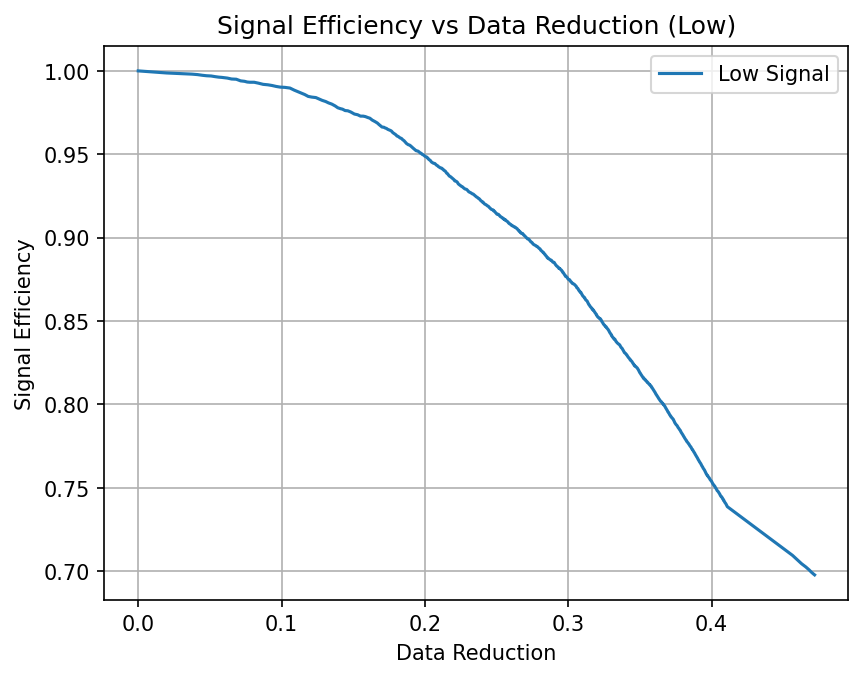

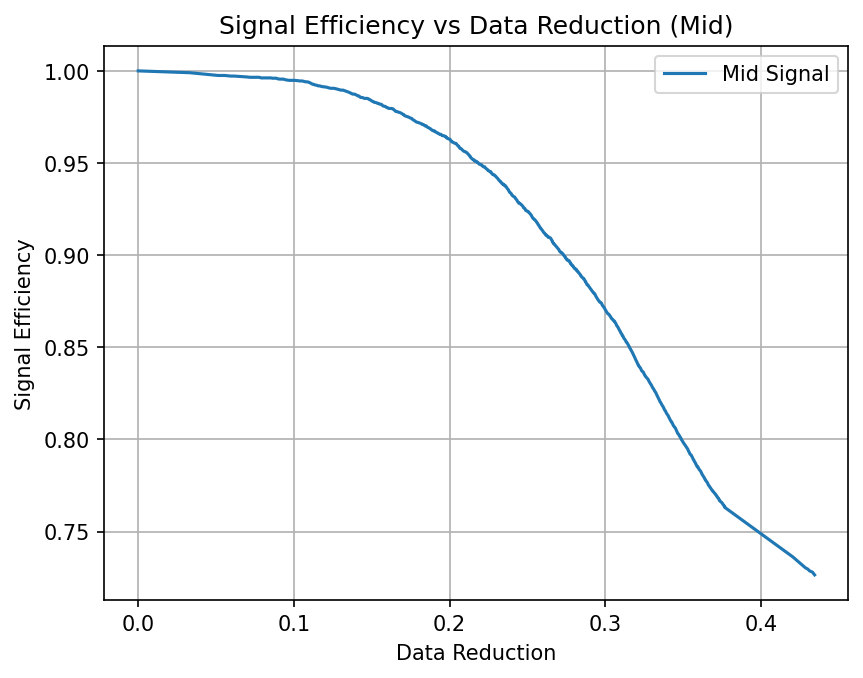

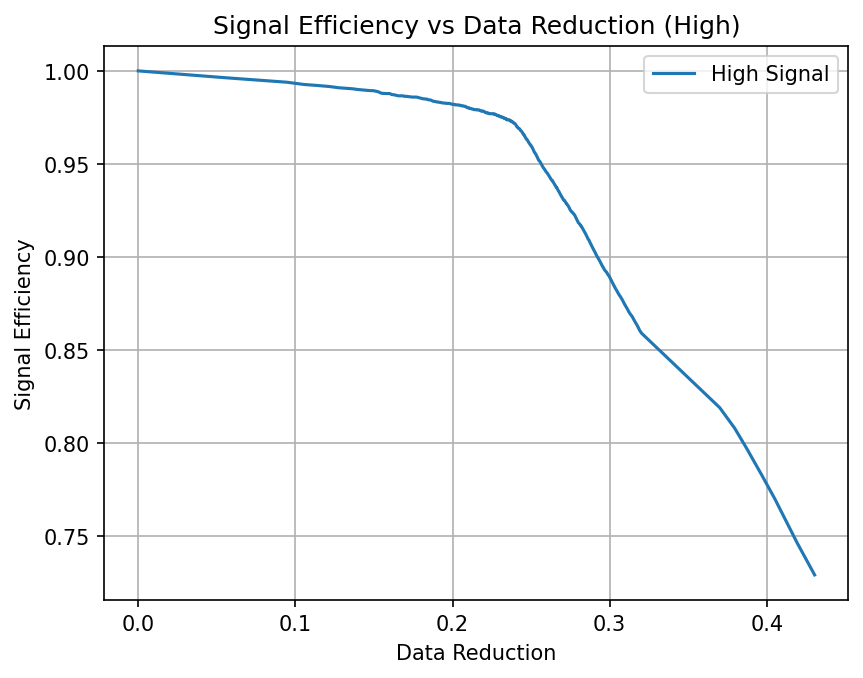

In [230]:
import matplotlib.pyplot as plt

# Assuming probabilities_low, probabilities_mid, and probabilities_high are already computed
probabilities = {
    "Low": {
        "bib": probabilities_low["bibLow"],
        "sig": probabilities_low["sigLow"],
    },
    "Mid": {
        "bib": probabilities_mid["bibMid"],
        "sig": probabilities_mid["sigMid"],
    },
    "High": {
        "bib": probabilities_high["bibHigh"],
        "sig": probabilities_high["sigHigh"],
    },
}

# Define the custom function
def custom_function(x, a, shift=0.01):
    f_a = np.tan(np.pi * a / 2)
    return (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift

# Define the calculate_efficiency_and_reduction function
def calculate_efficiency_and_reduction(probabilities, custom_func_params):
    results = {}

    a = custom_func_params.get("a", 0.5)
    shift = custom_func_params.get("shift", 0.05)

    for key in probabilities:
        bib = probabilities[key]["bib"]
        sig = probabilities[key]["sig"]

        sig_above = sum(1 for x, y in sig if y > custom_function(x, a, shift))
        sig_total = len(sig)

        signal_efficiency = sig_above / sig_total if sig_total > 0 else 0

        combined = bib + sig
        total_points = len(combined)
        points_below = sum(1 for x, y in combined if y <= custom_function(x, a, shift))

        data_reduction = points_below / total_points if total_points > 0 else 0

        results[key] = {
            "signal_efficiency": signal_efficiency,
            "data_reduction": data_reduction,
        }

    return results

# Iterate over a range of "a" values to calculate and store results
a_values = np.linspace(0, 1, 500)
results_over_a = {key: {"efficiency": [], "reduction": []} for key in probabilities}

for a in a_values:
    custom_func_params = {"a": a, "shift": 0.01}
    results = calculate_efficiency_and_reduction(probabilities, custom_func_params)
    for key in probabilities:
        results_over_a[key]["efficiency"].append(results[key]["signal_efficiency"])
        results_over_a[key]["reduction"].append(results[key]["data_reduction"])

# Plot Signal Efficiency vs Data Reduction for each category
for category in ["Low", "Mid", "High"]:
    plt.figure()
    plt.plot(
        results_over_a[category]["reduction"],
        results_over_a[category]["efficiency"],
        label=f"{category} Signal",
    )
    plt.title(f"Signal Efficiency vs Data Reduction ({category})")
    plt.xlabel("Data Reduction")
    plt.ylabel("Signal Efficiency")
    plt.legend()
    plt.grid()
    plt.show()



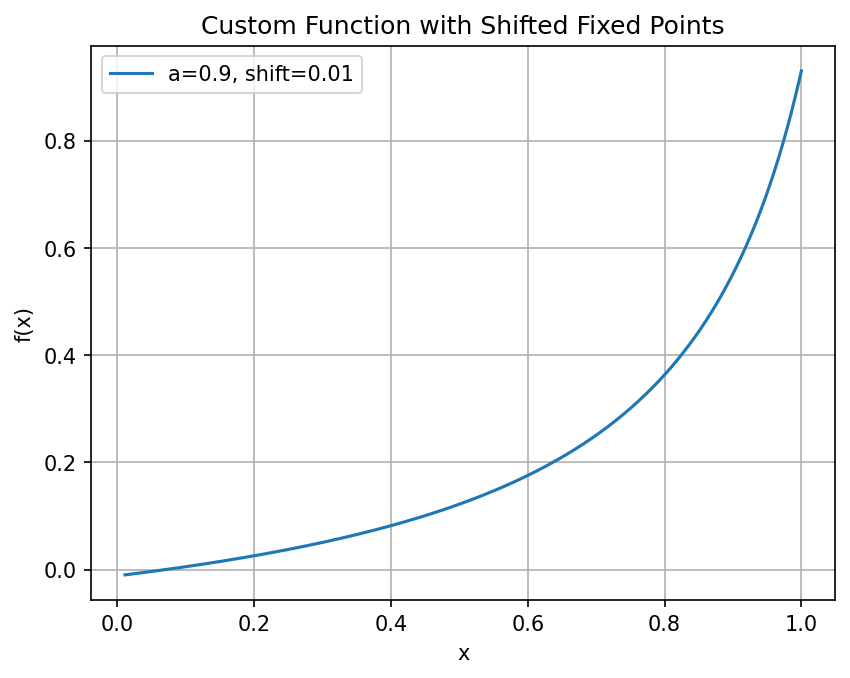

In [229]:
import numpy as np
import matplotlib.pyplot as plt

def custom_function(x, a, shift=0.01):
    # Define f(a) as tan(pi * a / 2)
    f_a = np.tan(np.pi * a / 2)
    # Compute the shifted function using the shift parameter
    result = (x - shift) / ((x - shift) + f_a * (1 - (x - shift))) - shift
    return result

# Example usage
a = 0.9  # Example value for a
shift = 0.01  # Default shift value
x = np.linspace(shift + 0.001, 1, 10000)  # Avoid division by zero
y = custom_function(x, a, shift)

# Plot the function for visualization
plt.plot(x, y, label=f'a={a}, shift={shift}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Function with Shifted Fixed Points')
plt.legend()
plt.grid()
plt.show()

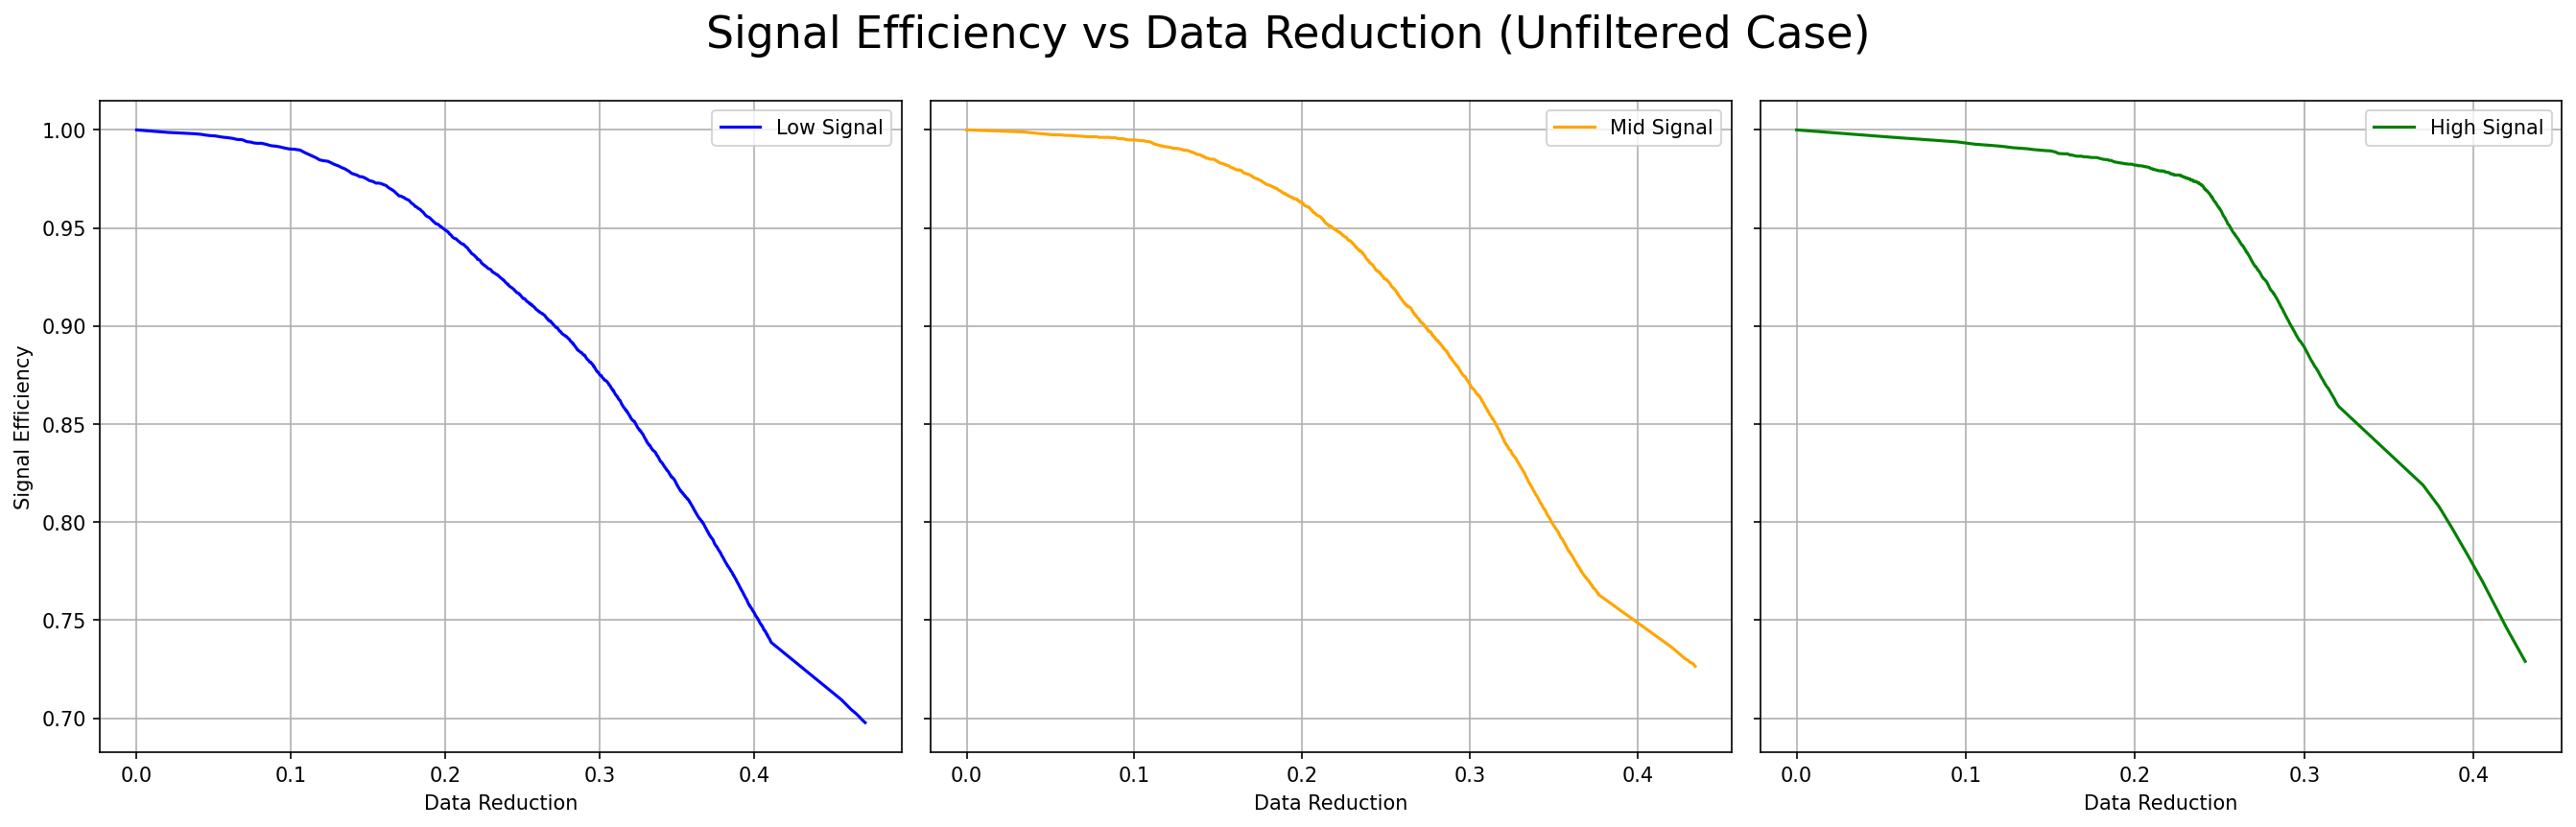

In [245]:
import matplotlib.pyplot as plt

# Combined plot with subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Categories and colors
categories = ["Low", "Mid", "High"]
colors = ["blue", "orange", "green"]

for i, category in enumerate(categories):
    axes[i].plot(
        results_over_a[category]["reduction"],
        results_over_a[category]["efficiency"],
        label=f"{category} Signal",
        color=colors[i]
    )
    axes[i].set_xlabel("Data Reduction")
    if i == 0:
        axes[i].set_ylabel("Signal Efficiency")
    axes[i].legend()
    axes[i].grid()

# Overarching title with larger font size
fig.suptitle("Signal Efficiency vs Data Reduction (Unfiltered Case)", fontsize=22, y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


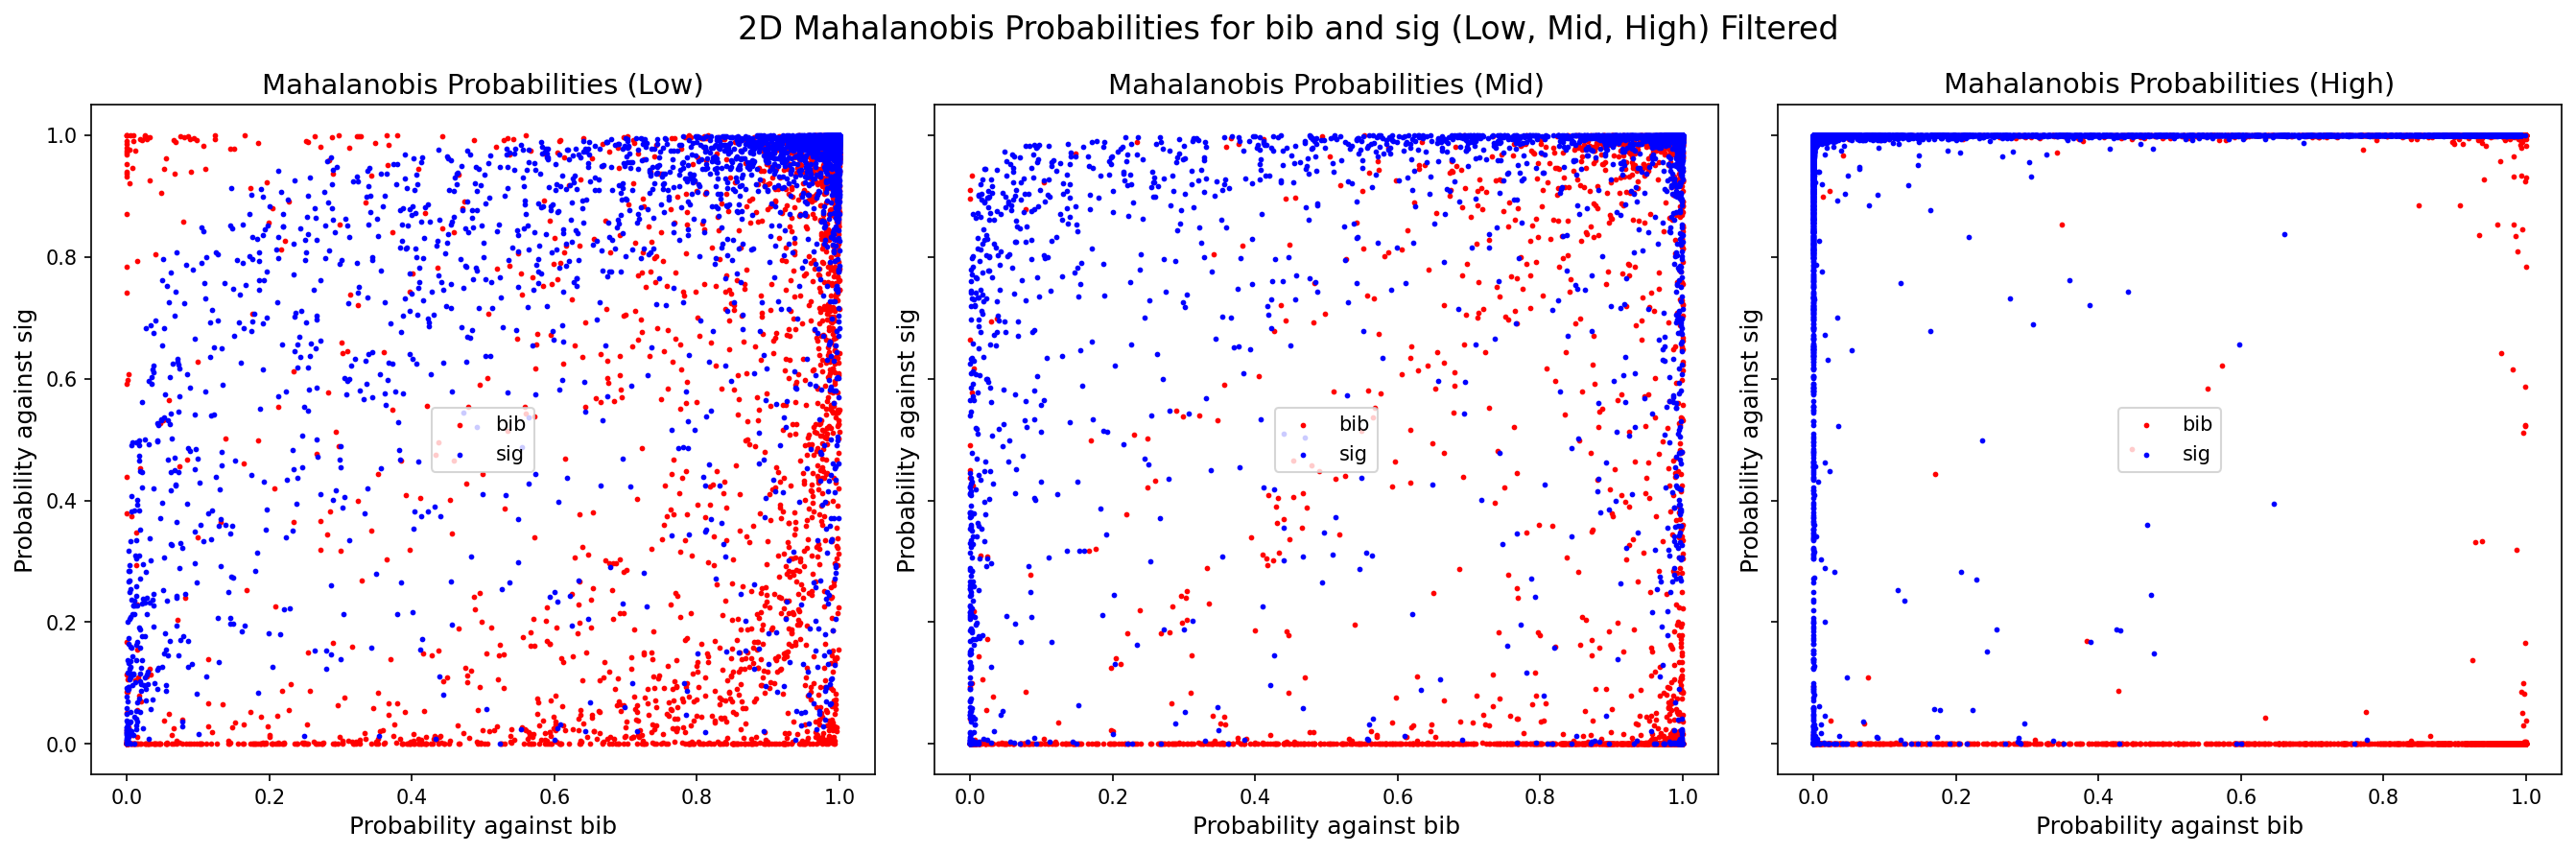

In [250]:
# Datasets, labels, and colors
filtered_datasets_low = [filtered_clustersbibLow, filtered_clusterssigLow]
filtered_datasets_mid = [filtered_clustersbibMid, filtered_clusterssigMid]
filtered_datasets_high = [filtered_clustersbibHigh, filtered_clusterssigHigh]

dataset_labels = ['bib', 'sig']
dataset_colors = ['red', 'blue']

# Create subplots for Low, Mid, and High
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Low
create_2d_mahalanobis_plot(filtered_datasets_low, dataset_labels, dataset_colors,
                           filtered_datasets_low, 'Mahalanobis Probabilities (Low)', axes[0])

# Plot for Mid
create_2d_mahalanobis_plot(filtered_datasets_mid, dataset_labels, dataset_colors,
                           filtered_datasets_mid, 'Mahalanobis Probabilities (Mid)', axes[1])

# Plot for High
create_2d_mahalanobis_plot(filtered_datasets_high, dataset_labels, dataset_colors,
                           filtered_datasets_high, 'Mahalanobis Probabilities (High)', axes[2])

# Add an overall title and show the plots
fig.suptitle('2D Mahalanobis Probabilities for bib and sig (Low, Mid, High) Filtered', fontsize=16)
plt.tight_layout()
plt.show()

In [251]:

# Compute probabilities for Low, Mid, and High datasets
probabilities_low_filtered = {}
probabilities_mid_filtered = {}
probabilities_high_filtered = {}

# Compute probabilities for Low datasets
probabilities_low_filtered['bibLow'] = compute_probabilities_2d(filtered_datasets_low[0], filtered_datasets_low)
probabilities_low_filtered['sigLow'] = compute_probabilities_2d(filtered_datasets_low[1], filtered_datasets_low)

# Compute probabilities for Mid datasets
probabilities_mid_filtered['bibMid'] = compute_probabilities_2d(filtered_datasets_mid[0], filtered_datasets_mid)
probabilities_mid_filtered['sigMid'] = compute_probabilities_2d(filtered_datasets_mid[1], filtered_datasets_mid)

# Compute probabilities for High datasets
probabilities_high_filtered['bibHigh'] = compute_probabilities_2d(filtered_datasets_high[0], filtered_datasets_high)
probabilities_high_filtered['sigHigh'] = compute_probabilities_2d(filtered_datasets_high[1], filtered_datasets_high)

# Example usage
custom_func_params = {"a": 0.9, "shift": 0.05}

# Define probabilities for Low, Mid, and High datasets
probabilities_filtered = {
    "Low": {"bib": probabilities_low_filtered["bibLow"], "sig": probabilities_low_filtered["sigLow"]},
    "Mid": {"bib": probabilities_mid_filtered["bibMid"], "sig": probabilities_mid_filtered["sigMid"]},
    "High": {"bib": probabilities_high_filtered["bibHigh"], "sig": probabilities_high_filtered["sigHigh"]},
}

# Calculate results
results = calculate_efficiency_and_reduction(probabilities_filtered, custom_func_params)

# Output the results
print("Results:", results)

Results: {'Low': {'signal_efficiency': 0.9637227920940705, 'data_reduction': 0.14546542951212213}, 'Mid': {'signal_efficiency': 0.9472704714640199, 'data_reduction': 0.22333571939871152}, 'High': {'signal_efficiency': 0.9984871406959153, 'data_reduction': 0.1819315505057503}}


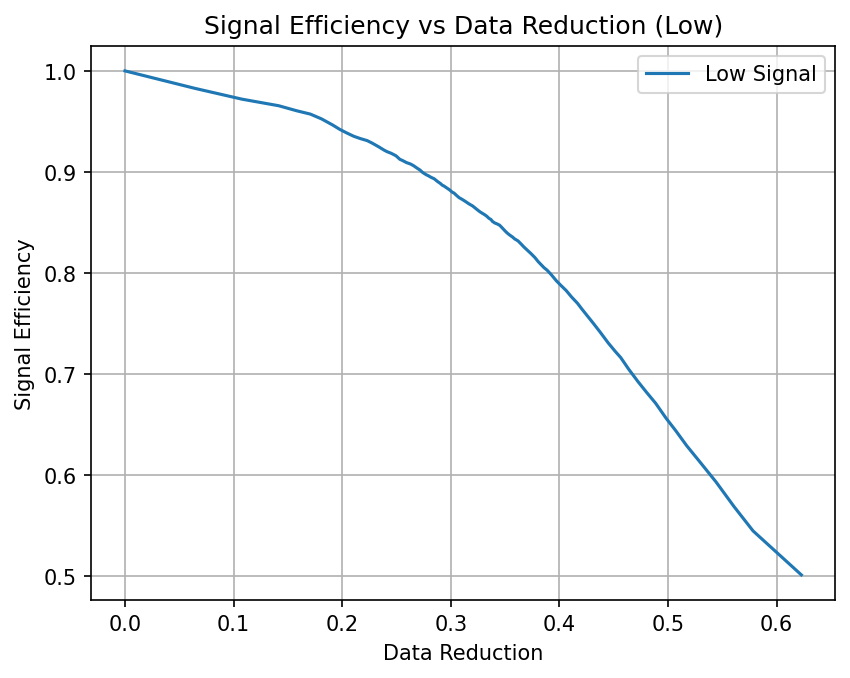

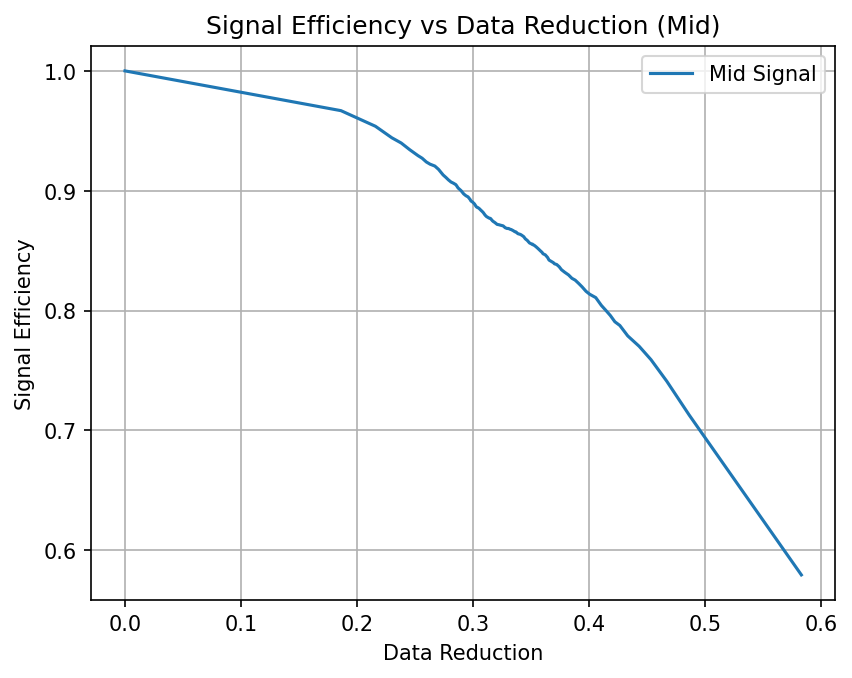

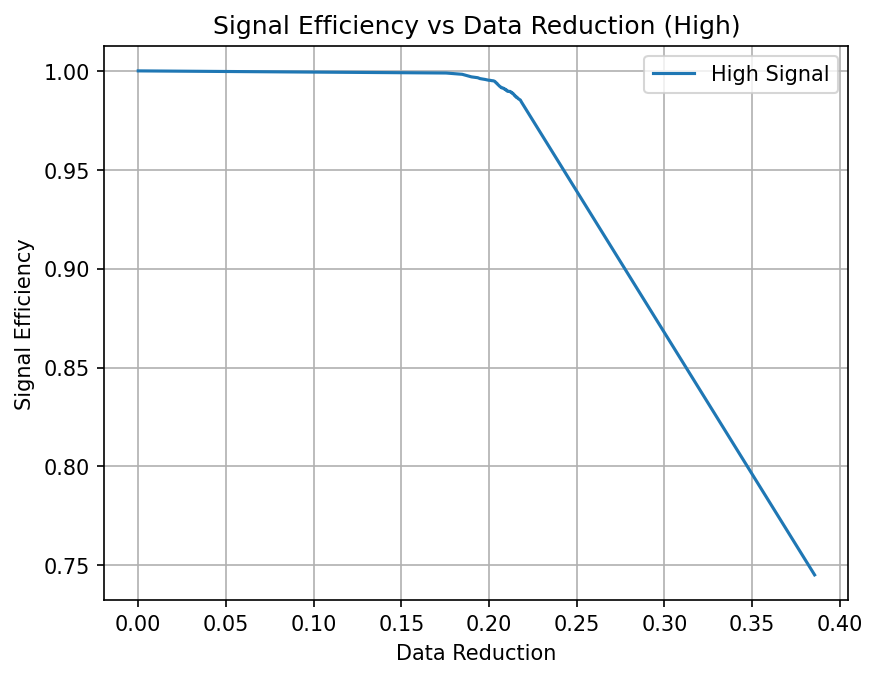

In [ ]:
# Iterate over a range of "a" values to calculate and store results
a_values = np.linspace(0, 1, 100)
results_over_a = {key: {"efficiency": [], "reduction": []} for key in probabilities_filtered}

for a in a_values:
    custom_func_params = {"a": a, "shift": 0.01}
    results = calculate_efficiency_and_reduction(probabilities_filtered, custom_func_params)
    for key in probabilities_filtered:
        results_over_a[key]["efficiency"].append(results[key]["signal_efficiency"])
        results_over_a[key]["reduction"].append(results[key]["data_reduction"])

# Plot Signal Efficiency vs Data Reduction for each category
for category in ["Low", "Mid", "High"]:
    plt.figure()
    plt.plot(
        results_over_a[category]["reduction"],
        results_over_a[category]["efficiency"],
        label=f"{category} Signal",
    )
    plt.title(f"Signal Efficiency vs Data Reduction ({category}) filtered")
    plt.xlabel("Data Reduction")
    plt.ylabel("Signal Efficiency")
    plt.legend()
    plt.grid()
    plt.show()

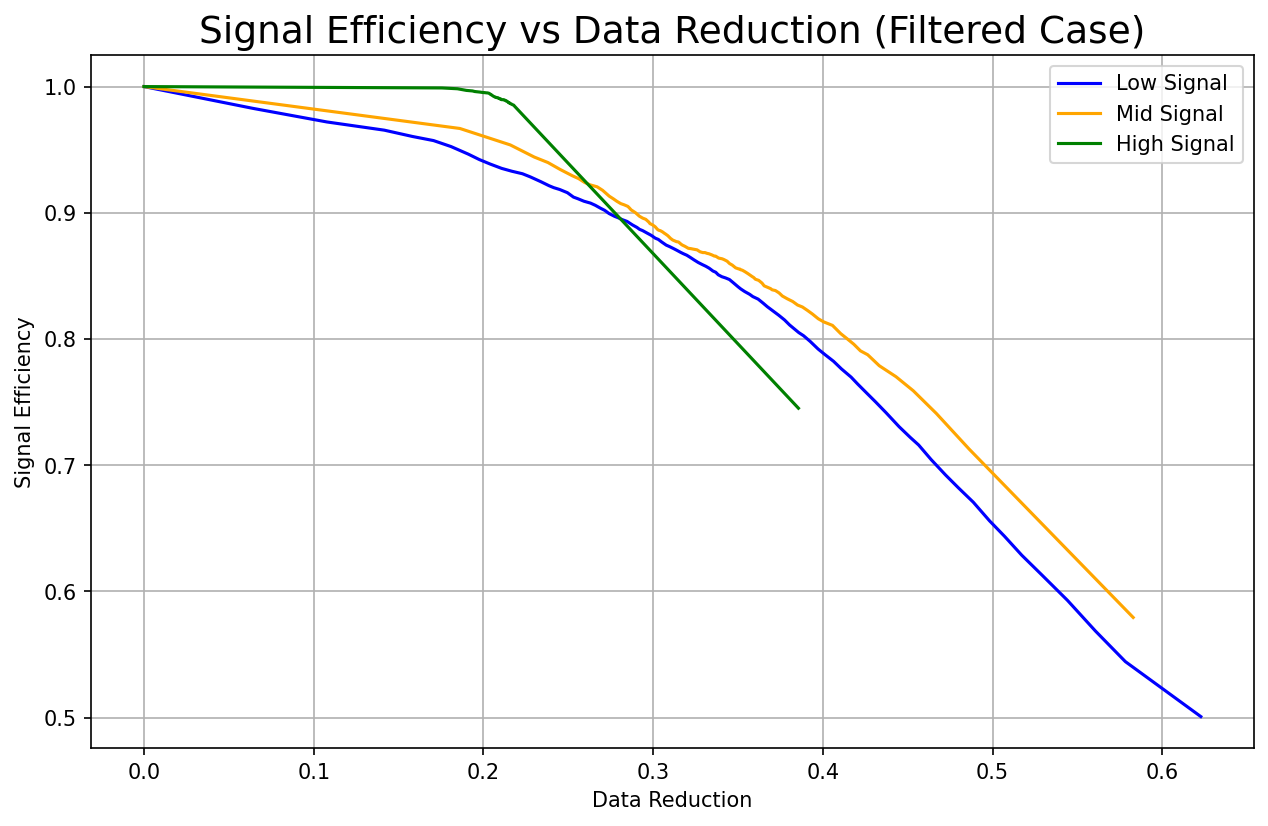

In [259]:
import matplotlib.pyplot as plt

# Combined plot for all categories on the same axis
plt.figure(figsize=(10, 6))

# Categories and colors
categories = ["Low", "Mid", "High"]
colors = ["blue", "orange", "green"]

for category, color in zip(categories, colors):
    plt.plot(
        results_over_a[category]["reduction"],
        results_over_a[category]["efficiency"],
        label=f"{category} Signal",
        color=color
    )

# Add labels and title
plt.xlabel("Data Reduction")
plt.ylabel("Signal Efficiency")
plt.title("Signal Efficiency vs Data Reduction (Filtered Case)", fontsize=18)
plt.legend()
plt.grid()

# Show the plot
plt.show()
